In [21]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('api_data_aadhar_enrolment/merged_final.csv')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Display first few rows
df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-09-01,Andaman And Nicobar Islands,Andamans,744101,0,1,0
1,2025-09-01,Andaman And Nicobar Islands,Andamans,744107,1,0,0
2,2025-09-01,Andaman And Nicobar Islands,Nicobar,744304,1,0,0
3,2025-09-01,Andaman And Nicobar Islands,Nicobar,744301,9,2,0
4,2025-09-01,Andaman And Nicobar Islands,North And Middle Andaman,744201,1,0,0


State-Wise grouped by Dates

In [23]:
# A. Time-based Features
# Data is grouped by date and state, daily totals are computed per state
state_daily = df.groupby(['state', 'date']).sum(numeric_only=True).reset_index()

# Display the state_daily dataframe
state_daily.head()

,state,date,pincode,age_0_5,age_5_17,age_18_greater
0,Andaman And Nicobar Islands,2025-09-01,9674150,22,3,0
1,Andaman And Nicobar Islands,2025-09-02,5209421,9,1,0
2,Andaman And Nicobar Islands,2025-09-03,5953538,11,1,0
3,Andaman And Nicobar Islands,2025-09-04,8929949,15,1,0
4,Andaman And Nicobar Islands,2025-09-05,2976615,5,0,0


In [ ]:
# B. Growth Calculation (Derived Feature)
# Day-over-day growth for Aadhaar counts
# Sort by state and date, then calculate pct_change per state for numeric columns only
numeric_cols = state_daily.select_dtypes(include='number').columns.tolist()
growth_df = (
    state_daily
    .sort_values(['state', 'date'])
    .groupby('state')[numeric_cols]
    .pct_change()
)

# Rename columns to indicate growth
growth_df.columns = [col + '_growth' for col in growth_df.columns]

# Combine with state_daily
state_daily_growth = pd.concat([state_daily, growth_df], axis=1)

# Display
state_daily_growth.head()

,state,date,pincode,age_0_5,age_5_17,age_18_greater,pincode_growth,age_0_5_growth,age_5_17_growth,age_18_greater_growth
0,Andaman And Nicobar Islands,2025-09-01,9674150,22,3,0,NaN,NaN,NaN,NaN
1,Andaman And Nicobar Islands,2025-09-02,5209421,9,1,0,-0.461511,-0.590909,-0.666667,NaN
2,Andaman And Nicobar Islands,2025-09-03,5953538,11,1,0,0.142841,0.222222,0.000000,NaN
3,Andaman And Nicobar Islands,2025-09-04,8929949,15,1,0,0.499940,0.363636,0.000000,NaN
4,Andaman And Nicobar Islands,2025-09-05,2976615,5,0,0,-0.666671,-0.666667,-1.000000,NaN


In [25]:
# C. Age-group Aggregation
# Specific age bands: age_0_5, age_5_17 (children/adolescents) and age_18_greater (adults)

# For state_daily, we already have sums
# Let's create a comparison dataframe
age_comparison = state_daily[['state', 'date', 'age_0_5', 'age_5_17', 'age_18_greater']].copy()
age_comparison['total_enrollments'] = age_comparison['age_0_5'] + age_comparison['age_5_17'] + age_comparison['age_18_greater']
age_comparison['pct_age_0_5'] = age_comparison['age_0_5'] / age_comparison['total_enrollments']
age_comparison['pct_children_adolescents'] = age_comparison['age_5_17'] / age_comparison['total_enrollments']
age_comparison['pct_adults'] = age_comparison['age_18_greater'] / age_comparison['total_enrollments']

# Display
age_comparison.head()

,state,date,age_0_5,age_5_17,age_18_greater,total_enrollments,pct_age_0_5,pct_children_adolescents,pct_adults
0,Andaman And Nicobar Islands,2025-09-01,22,3,0,25,0.880000,0.120000,0.0
1,Andaman And Nicobar Islands,2025-09-02,9,1,0,10,0.900000,0.100000,0.0
2,Andaman And Nicobar Islands,2025-09-03,11,1,0,12,0.916667,0.083333,0.0
3,Andaman And Nicobar Islands,2025-09-04,15,1,0,16,0.937500,0.062500,0.0
4,Andaman And Nicobar Islands,2025-09-05,5,0,0,5,1.000000,0.000000,0.0


In [26]:
# Compute total enrollments per state and sort by highest enrollment
state_totals = state_daily.groupby('state').sum(numeric_only=True).reset_index()
state_totals['total_enrollment'] = state_totals['age_0_5'] + state_totals['age_5_17'] + state_totals['age_18_greater']
state_totals_sorted = state_totals.sort_values('total_enrollment', ascending=False)

top_5_states = state_totals_sorted['state'].head(5).tolist()
bottom_5_states = state_totals_sorted['state'].tail(5).tolist()

print("Top 5 states by total enrollment:", top_5_states)
print("Bottom 5 states by total enrollment:", bottom_5_states)

Top 5 states by total enrollment: ['Uttar Pradesh', 'Bihar', 'Madhya Pradesh', 'West Bengal', 'Maharashtra']
Bottom 5 states by total enrollment: ['Sikkim', 'Dadra And Nagar Haveli And Daman And Diu', 'Ladakh', 'Andaman And Nicobar Islands', 'Lakshadweep']


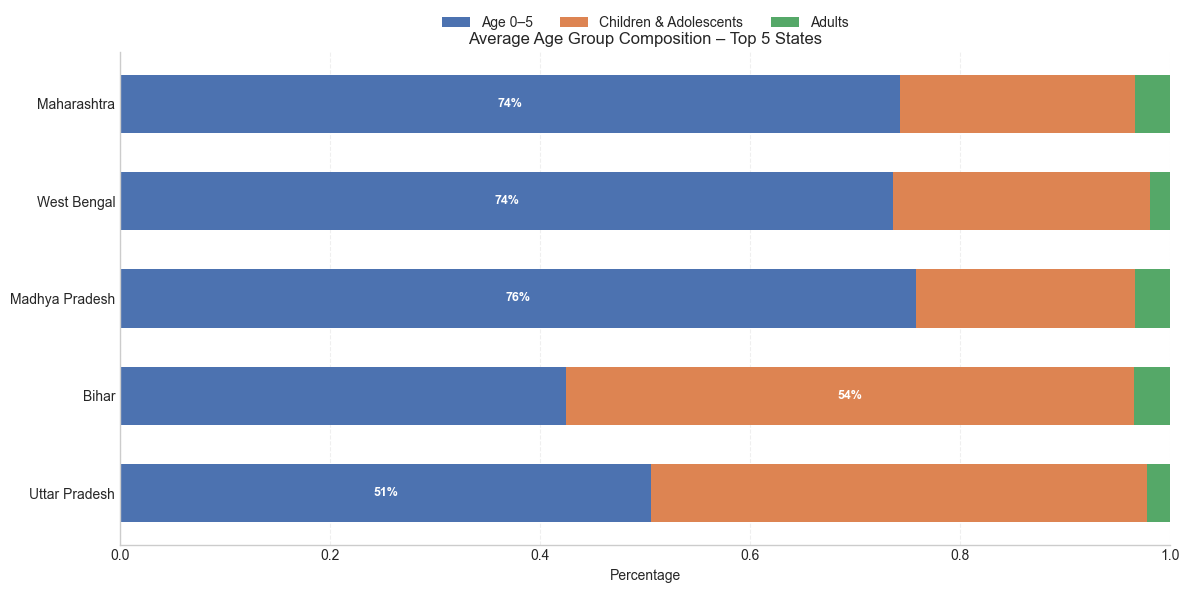

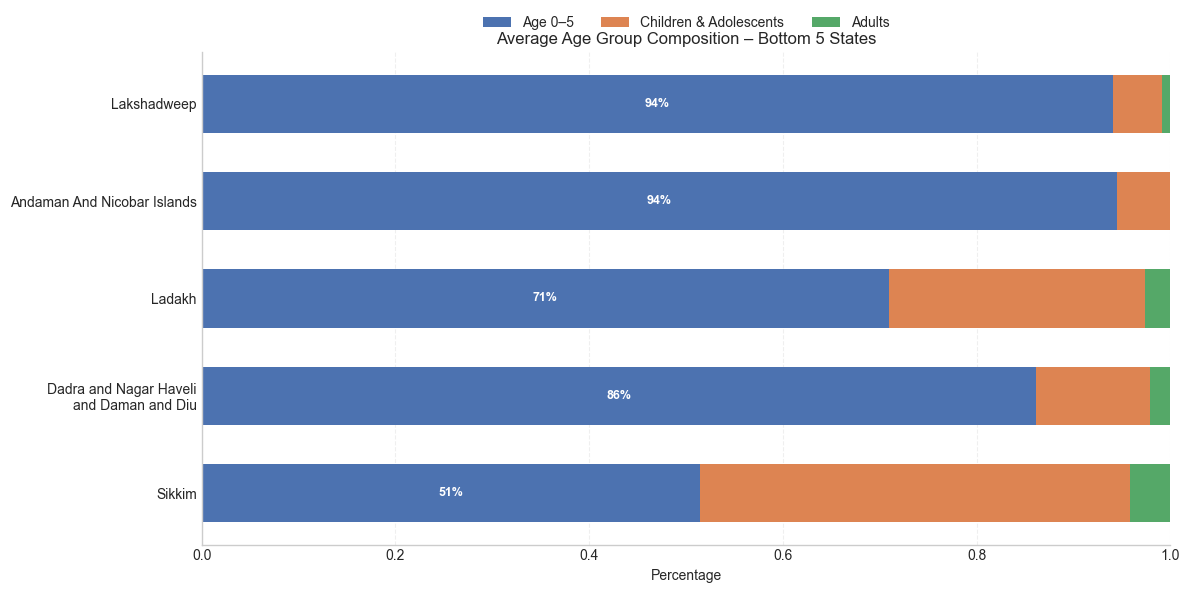

In [60]:
def wrap_state_label(name):
    if name.lower() == "dadra and nagar haveli and daman and diu":
        return "Dadra and Nagar Haveli\nand Daman and Diu"
    return name


def plot_clean_stacked_pct(df, states, title, figsize=(12, 6)):
    df_plot = df[df['state'].isin(states)].set_index('state')[cols]
    df_plot = df_plot.loc[states]

    # wrapped state labels
    state_labels = [wrap_state_label(s) for s in df_plot.index]

    fig, ax = plt.subplots(figsize=figsize)

    y = np.arange(len(state_labels))
    left = np.zeros(len(state_labels))

    age_labels = ['Age 0–5', 'Children & Adolescents', 'Adults']

    for i, col in enumerate(cols):
        values = df_plot[col].values

        ax.barh(
            y,
            values,
            left=left,
            color=colors[i],
            height=0.6,
            label=age_labels[i]
        )

        # annotate only dominant segment per state
        for j, v in enumerate(values):
            if v == df_plot.iloc[j].max():
                ax.text(
                    left[j] + v / 2,
                    y[j],
                    f"{v:.0%}",
                    ha='center',
                    va='center',
                    fontsize=9,
                    color='white',
                    weight='bold'
                )

        left += values

    ax.set_yticks(y)
    ax.set_yticklabels(state_labels)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Percentage')
    ax.set_title(title)

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=3,
        frameon=False
    )

    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.grid(axis='y', visible=False)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()
plot_clean_stacked_pct(
    avg_pct,
    top_5_states,
    "Average Age Group Composition – Top 5 States"
)

plot_clean_stacked_pct(
    avg_pct,
    bottom_5_states,
    "Average Age Group Composition – Bottom 5 States"
)


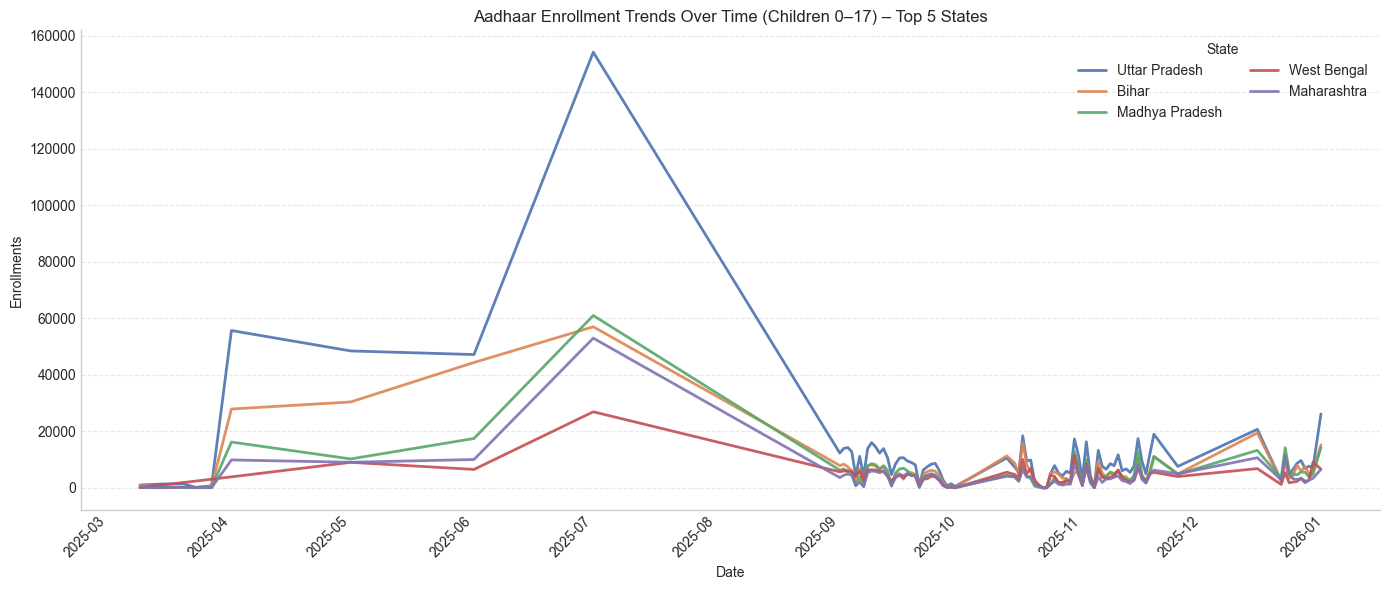

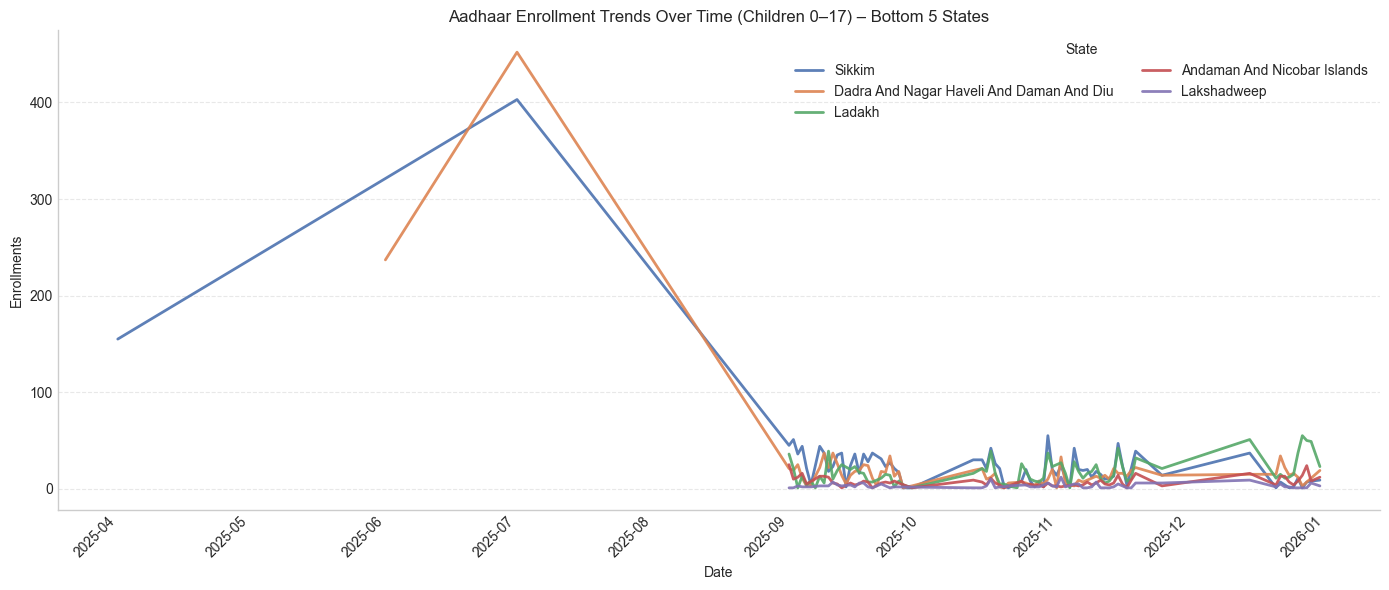

In [55]:
colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B3']
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(14, 6))


for state, color in zip(top_5_states, colors):
    state_data = state_daily[state_daily['state'] == state].sort_values('date')
    children_enrollment = state_data['age_0_5'] + state_data['age_5_17']

    plt.plot(
        state_data['date'],
        children_enrollment,
        label=state,
        color=color,
        linewidth=2,
        alpha=0.9
    )

plt.title('Aadhaar Enrollment Trends Over Time (Children 0–17) – Top 5 States')
plt.xlabel('Date')
plt.ylabel('Enrollments')
plt.xticks(rotation=45, ha='right')

plt.grid(axis="y", linestyle="--", alpha=0.45)
plt.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(title="State", frameon=False, ncol=2)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 6))

for state, color in zip(bottom_5_states, colors):
    state_data = state_daily[state_daily['state'] == state].sort_values('date')
    children_enrollment = state_data['age_0_5'] + state_data['age_5_17']

    plt.plot(
        state_data['date'],
        children_enrollment,
        label=state,
        color=color,
        linewidth=2,
        alpha=0.9
    )

plt.title('Aadhaar Enrollment Trends Over Time (Children 0–17) – Bottom 5 States')
plt.xlabel('Date')
plt.ylabel('Enrollments')
plt.xticks(rotation=45, ha='right')

plt.grid(axis="y", linestyle="--", alpha=0.45)
plt.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

plt.legend(title="State", frameon=False, ncol=2)
plt.tight_layout()
plt.show()


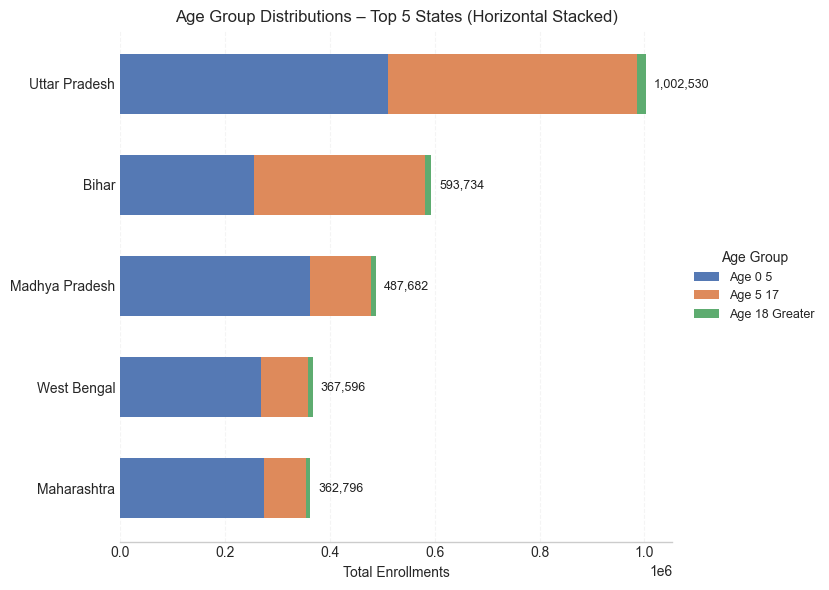

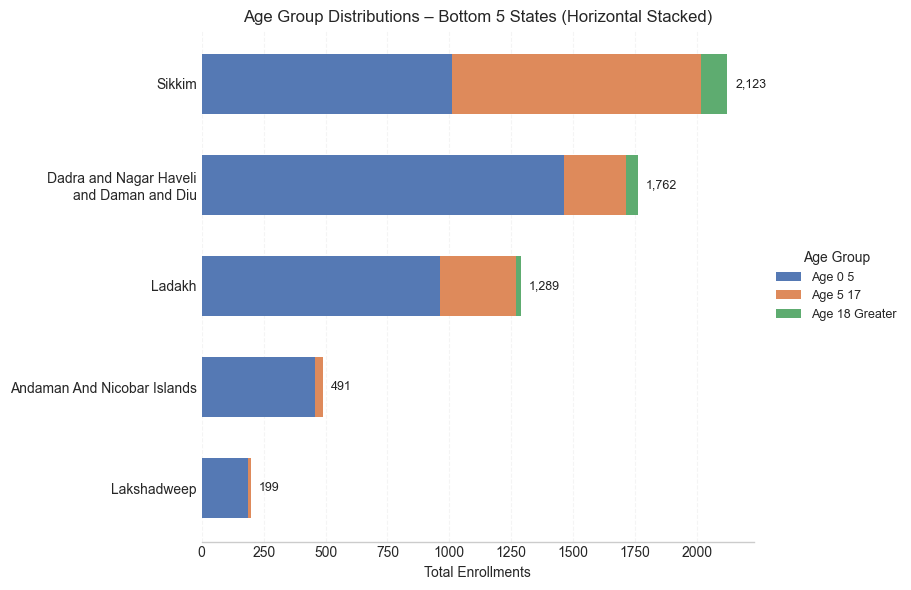

In [56]:
# 2. Bar Charts - Age-group distributions per state (total)
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

cols_counts = ['age_0_5', 'age_5_17', 'age_18_greater']
colors_counts = ['#4C72B0', '#DD8452', '#55A868']  # professional, colorblind-safe


# --- Helper to wrap long UT/state names cleanly ---
def wrap_state_label(name):
    if name.lower() == "dadra and nagar haveli and daman and diu":
        return "Dadra and Nagar Haveli\nand Daman and Diu"
    return name


def plot_horizontal_counts(df, states, title, figsize=(12, 6)):
    df_plot = df[df['state'].isin(states)].set_index('state')
    df_plot = df_plot.loc[states]  # preserve provided order

    # Apply label wrapping
    labels = [wrap_state_label(s) for s in df_plot.index]

    fig, ax = plt.subplots(figsize=figsize)
    y = np.arange(len(labels))
    left = np.zeros(len(labels))

    # Draw stacked horizontal bars
    for i, col in enumerate(cols_counts):
        vals = df_plot[col].values
        ax.barh(
            y,
            vals,
            left=left,
            color=colors_counts[i],
            height=0.6,
            label=col.replace('_', ' ').title(),
            alpha=0.95
        )
        left += vals

    # Annotate total enrollments at end of each bar
    totals = df_plot[cols_counts].sum(axis=1).values
    max_total = totals.max() if len(totals) > 0 else 0

    for j, t in enumerate(totals):
        ax.text(
            t + max_total * 0.015,
            y[j],
            f"{int(t):,}",
            va='center',
            fontsize=9,
            color='#222222'
        )

    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=10)
    ax.invert_yaxis()

    ax.set_xlabel('Total Enrollments')
    ax.set_title(title)

    # Subtle grid and clean spines
    ax.xaxis.grid(True, linestyle='--', alpha=0.2)
    ax.yaxis.grid(False)

    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    ax.legend(
        title='Age Group',
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        fontsize=9,
        title_fontsize=10
    )

    plt.tight_layout()
    plt.subplots_adjust(left=0.32, right=0.78)
    plt.show()


# Plot for top 5 states
plot_horizontal_counts(
    state_totals,
    top_5_states,
    'Age Group Distributions – Top 5 States (Horizontal Stacked)'
)

# Plot for bottom 5 states
plot_horizontal_counts(
    state_totals,
    bottom_5_states,
    'Age Group Distributions – Bottom 5 States (Horizontal Stacked)'
)


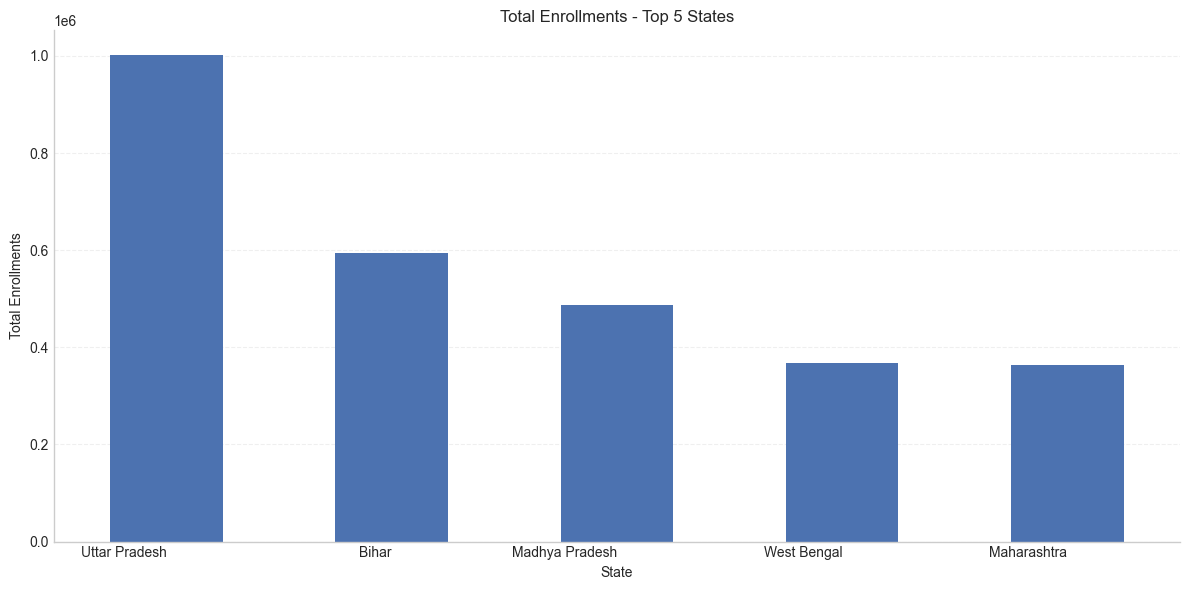

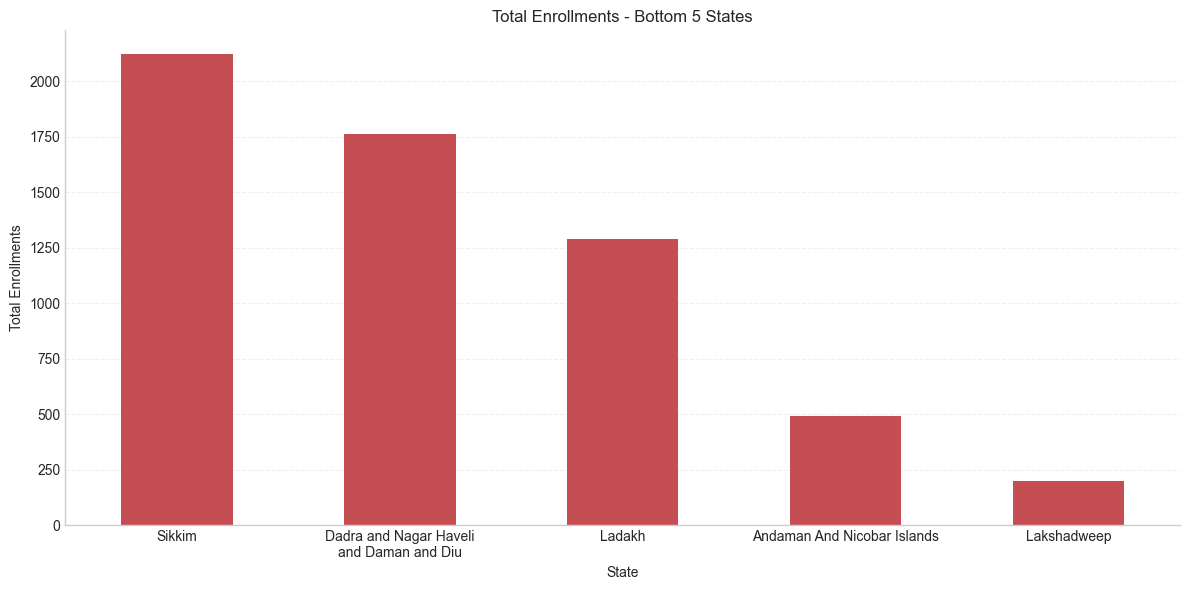

In [63]:
# 4. Bar Chart for Total Enrollments of Top 5 and Bottom 5 States
plt.style.use("seaborn-v0_8-whitegrid")

# Plot for top 5 states
plt.figure(figsize=(12, 6))
top_states = state_totals_sorted[state_totals_sorted['state'].isin(top_5_states)]
top_states.set_index('state')['total_enrollment'].plot(kind='bar', color='#4C72B0')
plt.title('Total Enrollments - Top 5 States')
plt.xlabel('State')
plt.ylabel('Total Enrollments')
plt.xticks(rotation=0, ha='right',fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.grid(axis="x", visible=False)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

# Plot for bottom 5 states
plt.figure(figsize=(12, 6))

bottom_states = state_totals_sorted[
    state_totals_sorted['state'].isin(bottom_5_states)
]

ax = bottom_states.set_index('state')['total_enrollment'].plot(
    kind='bar',
    color='#C44E52'
)

plt.title('Total Enrollments - Bottom 5 States')
plt.xlabel('State')
plt.ylabel('Total Enrollments')

# apply wrapping here
wrapped_labels = [wrap_state_label(s) for s in bottom_states['state']]
ax.set_xticklabels(wrapped_labels, rotation=0, ha='center', fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.grid(axis="x", visible=False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_12960\1901525499.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(['state','district', pd.Grouper(key='date', freq='M')])


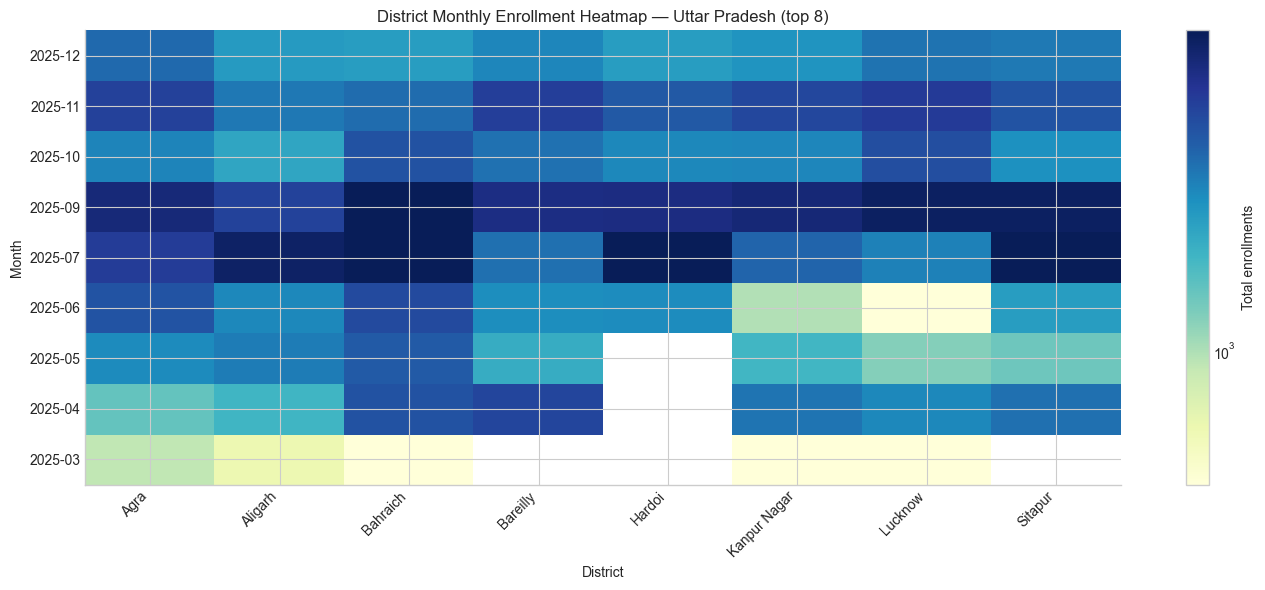

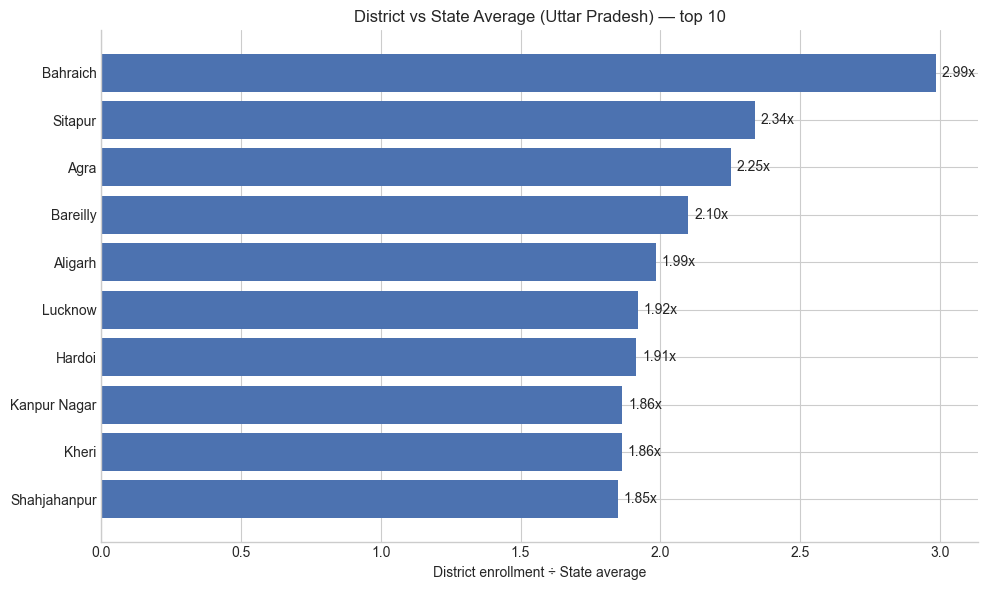

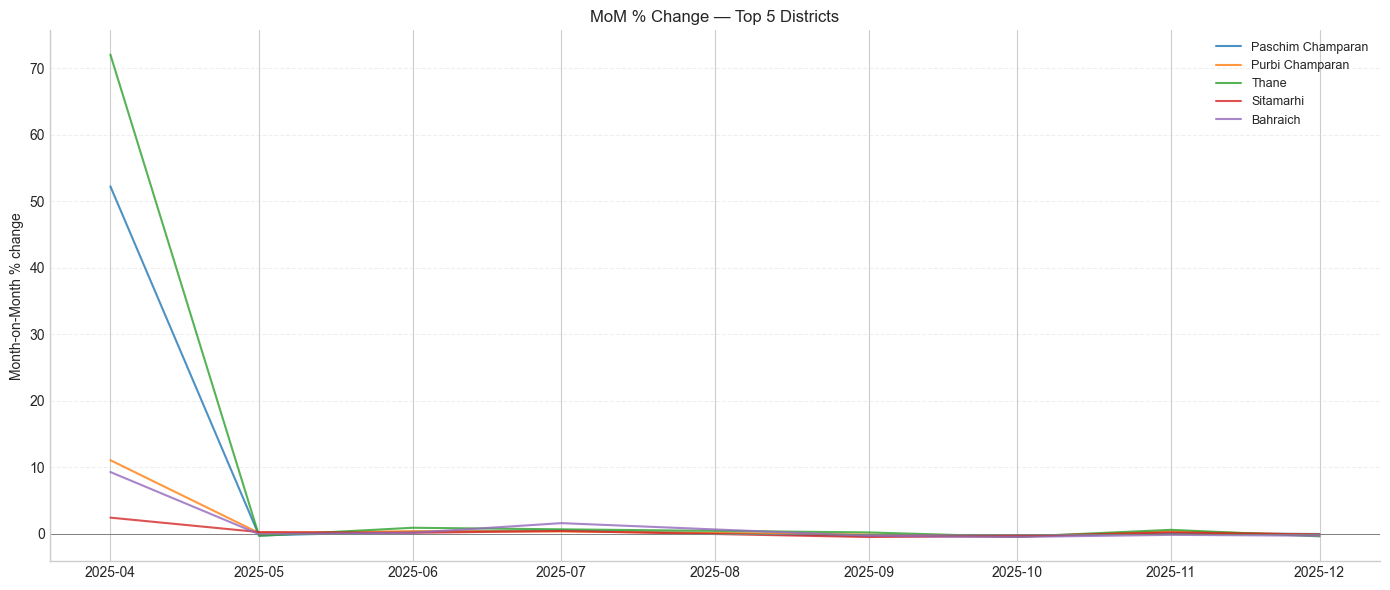

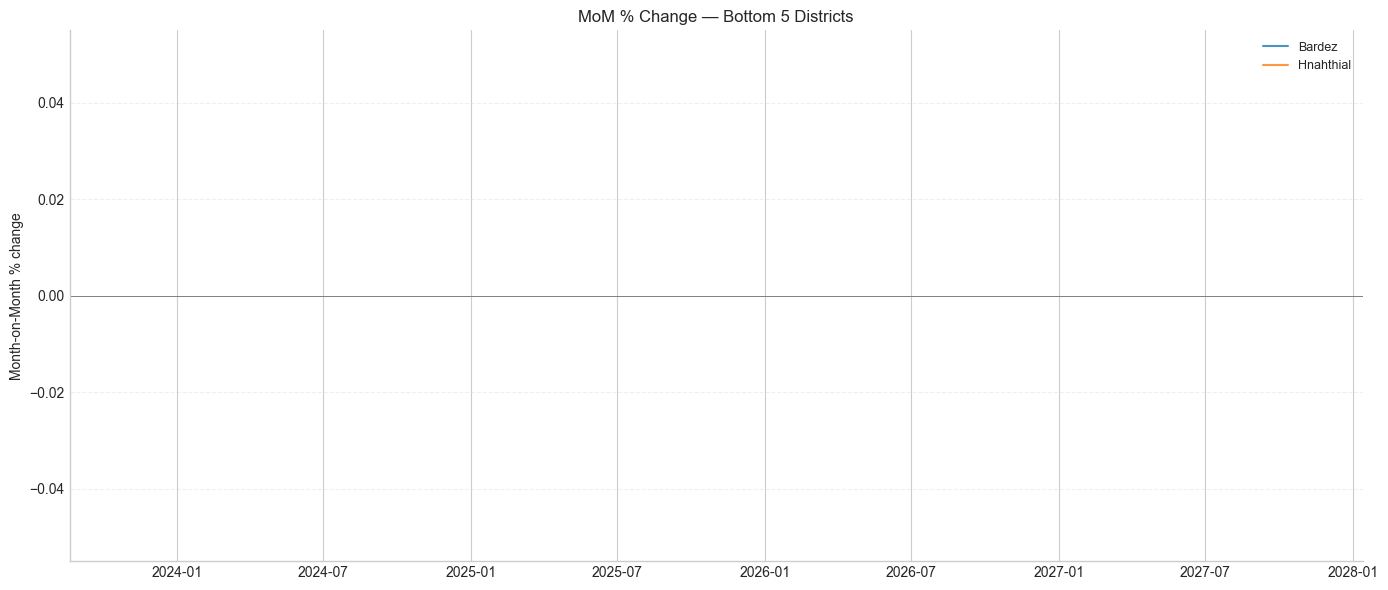

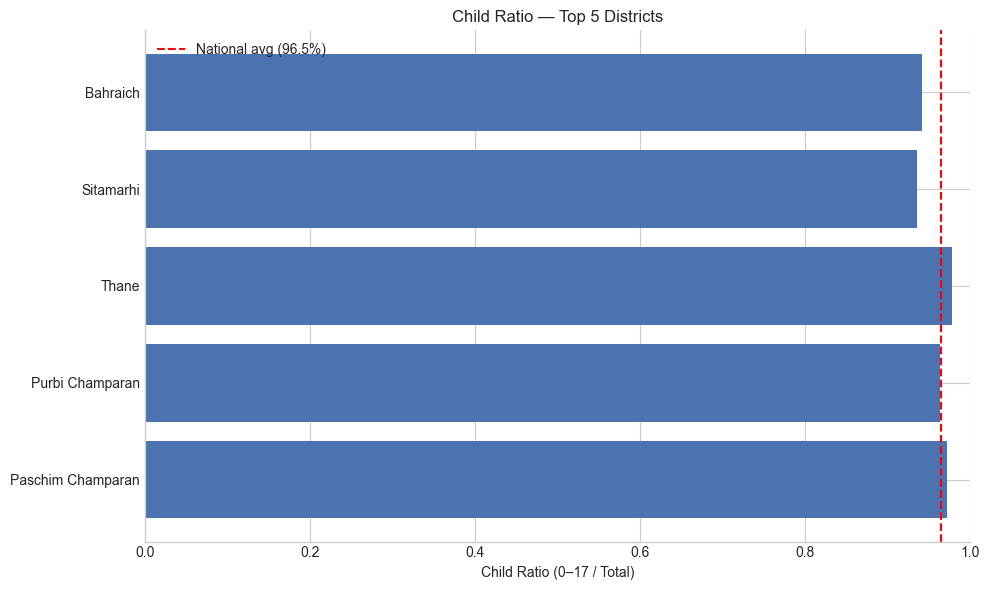

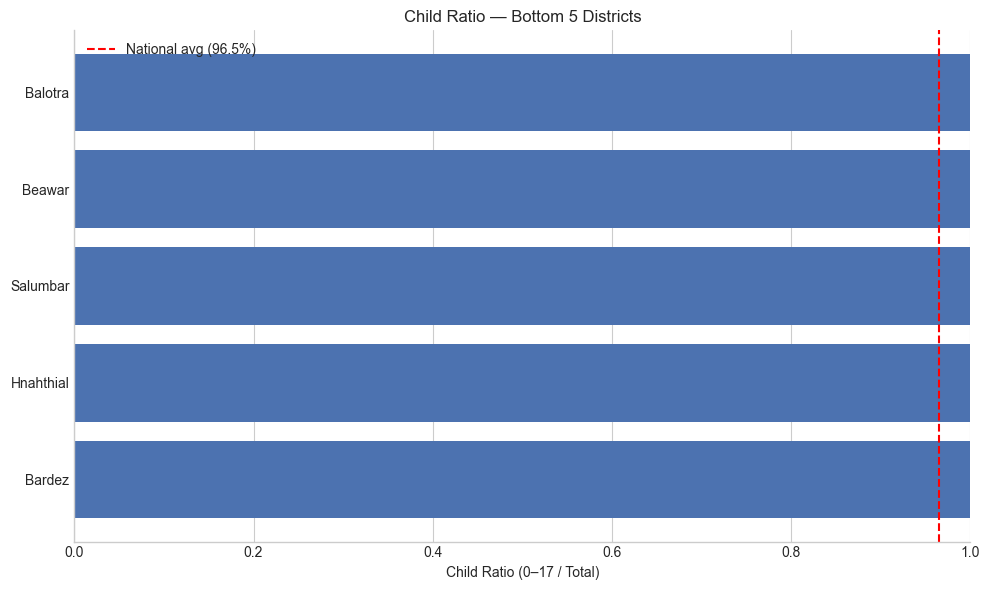

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_12960\1901525499.py:199: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


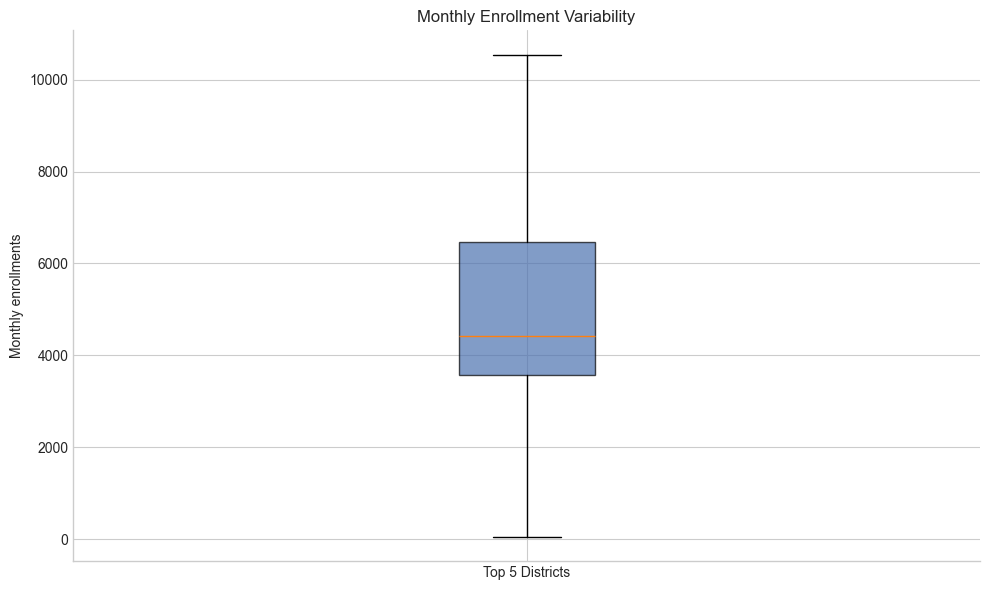

C:\Users\SINDHU\AppData\Local\Temp\ipykernel_12960\1901525499.py:199: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True)


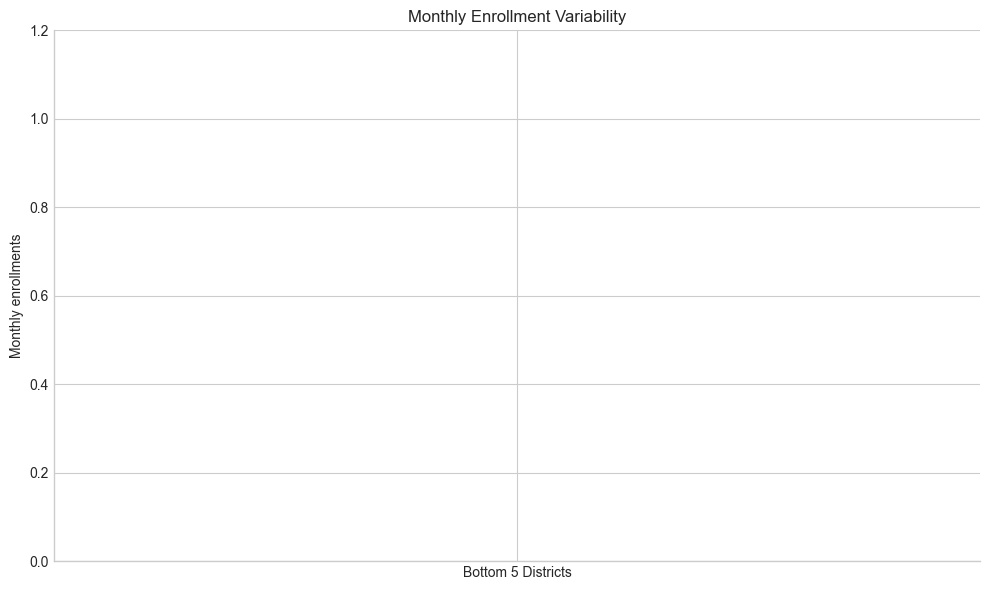

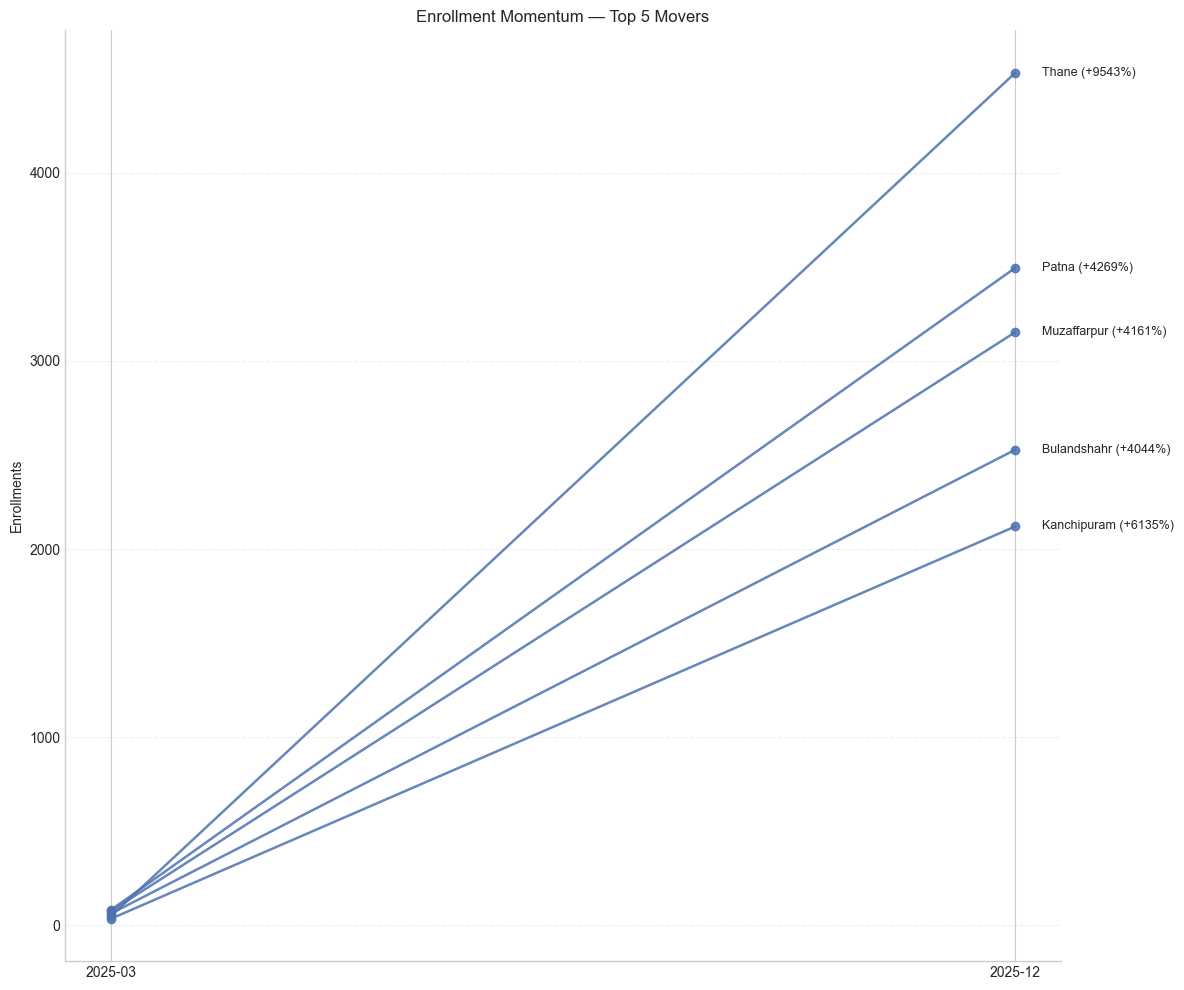

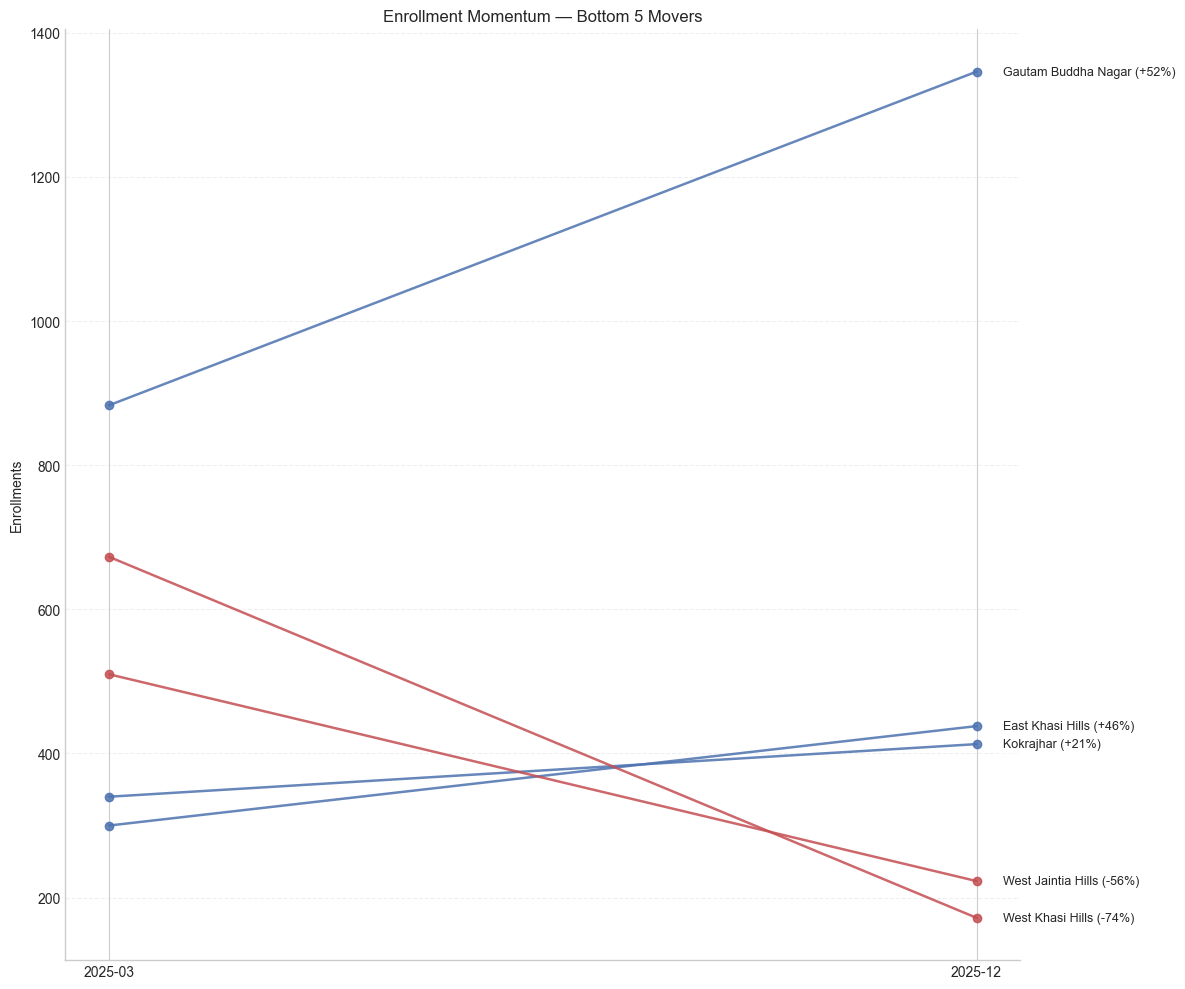

All enhanced visualizations generated successfully!


In [72]:
# --- District-level advanced visualizations (Heatmap, Ratio, MoM, Age-mix, Variability, Momentum) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.style.use("seaborn-v0_8-whitegrid")

# Prepare monthly aggregates by district
district_monthly = (
    df
    .groupby(['state','district', pd.Grouper(key='date', freq='M')])
    .sum(numeric_only=True)
    .reset_index()
)
district_monthly['month'] = district_monthly['date'].dt.to_period('M').astype(str)

district_monthly['total_enrollments'] = district_monthly[['age_0_5','age_5_17','age_18_greater']].sum(axis=1)

district_totals = district_monthly.groupby('district', as_index=False)['total_enrollments'].sum()
district_totals = district_totals.sort_values('total_enrollments', ascending=False)

state_by_total = state_totals_sorted['state'].iloc[0]

# ---------------------------------------------------------------------
# 1) HEATMAP WITH IMPROVED SCALING
# ---------------------------------------------------------------------
def plot_district_heatmap(state, top_n=8, cmap='YlGnBu', figsize=(14,6)):
    state_df = district_monthly[district_monthly['state'] == state].copy()
    if state_df.empty:
        print(f"No data for state: {state}")
        return

    tot = state_df.groupby('district', as_index=False)['total_enrollments'].sum()
    tot = tot.sort_values('total_enrollments', ascending=False)
    districts = tot['district'].head(top_n).tolist()

    pivot = (
        state_df[state_df['district'].isin(districts)]
        .pivot_table(index='month', columns='district', values='total_enrollments', aggfunc='sum')
        .fillna(0)
        .sort_index()
    )

    fig, ax = plt.subplots(figsize=figsize)

    data = pivot.values

    vmin = np.percentile(data[data > 0], 5)
    vmax = np.percentile(data, 95)

    norm = LogNorm(vmin=max(vmin, 1), vmax=vmax)

    im = ax.imshow(data, aspect='auto', origin='lower', cmap=cmap, norm=norm)

    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)

    ax.set_title(f"District Monthly Enrollment Heatmap — {state} (top {top_n})")
    ax.set_xlabel('District')
    ax.set_ylabel('Month')

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Total enrollments')

    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_district_heatmap(state_by_total, top_n=8)


# ---------------------------------------------------------------------
# 2) DISTRICT VS STATE AVERAGE
# ---------------------------------------------------------------------
def plot_district_vs_state_avg(state, top_n=10, figsize=(10,6)):
    state_totals = district_monthly[district_monthly['state']==state].groupby('district')['total_enrollments'].sum().reset_index()
    state_avg = state_totals['total_enrollments'].mean()
    state_totals['ratio_to_state_avg'] = state_totals['total_enrollments'] / state_avg
    state_totals = state_totals.sort_values('ratio_to_state_avg', ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(state_totals['district'], state_totals['ratio_to_state_avg'], color='#4C72B0')

    ax.set_xlabel('District enrollment ÷ State average')
    ax.set_title(f'District vs State Average ({state}) — top {top_n}')
    ax.invert_yaxis()

    for i, val in enumerate(state_totals['ratio_to_state_avg']):
        ax.text(val + 0.02, i, f"{val:.2f}x", va='center')

    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_district_vs_state_avg(state_by_total)


# ---------------------------------------------------------------------
# 3) MOMENTUM PLOTS – IMPROVED READABILITY
# ---------------------------------------------------------------------
district_mom = district_monthly.copy()
district_mom = district_mom.sort_values(['district','month'])
district_mom['mom_pct'] = district_mom.groupby('district')['total_enrollments'].pct_change()


def plot_mom_for_districts(districts, title, figsize=(14,6)):
    fig, ax = plt.subplots(figsize=figsize)

    for d in districts:
        s = district_mom[district_mom['district']==d]
        if s['mom_pct'].notna().any():
            ax.plot(pd.to_datetime(s['month']), s['mom_pct'], label=d, linewidth=1.5, alpha=0.8)

    ax.axhline(0, color='gray', linewidth=0.7)
    ax.set_ylabel('Month-on-Month % change')
    ax.set_title(title)
    ax.legend(fontsize=9, frameon=False)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


top_d = district_totals['district'].head(5).tolist()
bottom_d = district_totals['district'].tail(5).tolist()

plot_mom_for_districts(top_d, 'MoM % Change — Top 5 Districts')
plot_mom_for_districts(bottom_d, 'MoM % Change — Bottom 5 Districts')


# ---------------------------------------------------------------------
# 4) CHILD RATIO PLOTS
# ---------------------------------------------------------------------
district_age = district_monthly.groupby('district').agg({
    'age_0_5':'sum','age_5_17':'sum','age_18_greater':'sum'}).reset_index()

district_age['child_ratio'] = (district_age['age_0_5'] + district_age['age_5_17']) / (
    district_age['age_0_5'] + district_age['age_5_17'] + district_age['age_18_greater'])

national_avg_child = district_age['child_ratio'].mean()


def plot_child_ratio(districts, title, figsize=(10,6)):
    df_plot = district_age[district_age['district'].isin(districts)].set_index('district').loc[districts]

    fig, ax = plt.subplots(figsize=figsize)

    ax.barh(df_plot.index, df_plot['child_ratio'], color='#4C72B0')
    ax.axvline(national_avg_child, color='red', linestyle='--',
               label=f'National avg ({national_avg_child:.1%})')

    ax.set_xlim(0,1)
    ax.set_xlabel('Child Ratio (0–17 / Total)')
    ax.set_title(title)

    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()


plot_child_ratio(top_d, 'Child Ratio — Top 5 Districts')
plot_child_ratio(bottom_d, 'Child Ratio — Bottom 5 Districts')


# ---------------------------------------------------------------------
# 5) VARIABILITY BOXPLOTS – SEPARATED AND LOG SCALED
# ---------------------------------------------------------------------
monthly_by_district = district_monthly.pivot_table(
    index='month', columns='district', values='total_enrollments', aggfunc='sum')


def plot_variability_boxplot(groups, group_names, figsize=(10,6), use_log=False, custom_ylim=None):

    data = []
    labels = []

    for grp, name in zip(groups, group_names):
        vals = monthly_by_district[grp].dropna().values.flatten()
        data.append(vals)
        labels.append(name)

    fig, ax = plt.subplots(figsize=figsize)

    bp = ax.boxplot(data, labels=labels, patch_artist=True)

    colors_box = ['#4C72B0', '#C44E52']

    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Monthly enrollments')
    ax.set_title('Monthly Enrollment Variability')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    # ------ CRITICAL FIX PART ------

    if custom_ylim is not None:
        ax.set_ylim(custom_ylim)

    elif use_log:
        ax.set_yscale('log')
        ax.set_ylabel('Monthly enrollments (log scale)')

    plt.tight_layout()
    plt.show()



plot_variability_boxplot([top_d], ['Top 5 Districts'])
bottom_data = monthly_by_district[bottom_d].values.flatten()
max_val = np.nanmax(bottom_data)

plot_variability_boxplot(
    [bottom_d],
    ['Bottom 5 Districts'],
    custom_ylim=(0, max_val * 1.2)
)




# ---------------------------------------------------------------------
# 6) MOMENTUM SLOPE GRAPHS – FIXED LABEL COLLISIONS
# ---------------------------------------------------------------------
start_month = district_monthly['month'].min()
end_month = district_monthly['month'].max()

start_vals = district_monthly[district_monthly['month']==start_month].set_index('district')['total_enrollments']
end_vals = district_monthly[district_monthly['month']==end_month].set_index('district')['total_enrollments']

momentum = pd.DataFrame({'start': start_vals, 'end': end_vals}).dropna()
momentum['change_pct'] = (momentum['end'] - momentum['start']) / momentum['start']

momentum_sorted = momentum.sort_values('change_pct', ascending=False)


def plot_slope_group(df_rows, title, figsize=(12,10)):
    fig, ax = plt.subplots(figsize=figsize)

    plt.subplots_adjust(right=0.70)

    max_val = max(df_rows['start'].max(), df_rows['end'].max())
    use_log = max_val > 10000

    for idx, row in df_rows.iterrows():
        start = row['start']
        end = row['end']
        pct = (end - start) / start

        color = '#4C72B0' if pct >= 0 else '#C44E52'

        ax.plot([0,1],[start, end], marker='o', color=color,
                alpha=0.85, linewidth=1.8)

        ax.text(1.03, end,
                f"{idx} ({pct:+.0%})",
                va='center',
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax.set_xticks([0,1])
    ax.set_xticklabels([start_month, end_month])
    ax.set_title(title)

    if use_log:
        ax.set_yscale('log')
        ax.set_ylabel('Enrollments (log scale)')
    else:
        ax.set_ylabel('Enrollments')

    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_slope_group(momentum_sorted.head(5), 'Enrollment Momentum — Top 5 Movers')
plot_slope_group(momentum_sorted.tail(5), 'Enrollment Momentum — Bottom 5 Movers')


print("All enhanced visualizations generated successfully!")


# PART A — INITIAL EXPLORATION ON RAW DATA

We perform EDA directly on the raw, cleaned dataset (deduped & standardized). Steps:
- Inspect date ranges, state/district counts
- Daily enrollment distributions (histogram, boxplot, time series)
- Missing values visualization
- Outlier & anomaly detection (IQR + z-score + pct-change MAD)
- Summary tables: total enrollments by state and district, age-group shares

Date range: 2025-03-02 to 2025-12-31
Number of states: 36
Number of districts: 791


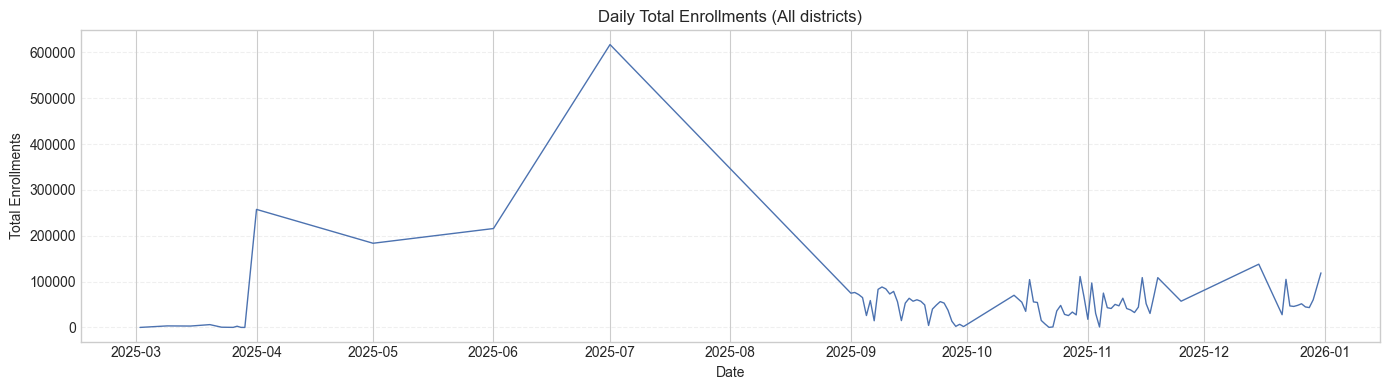


Daily totals - descriptive statistics:
count        92.000000
mean      57821.250000
std       73736.317344
min          67.000000
25%       25990.000000
50%       48155.000000
75%       67453.750000
max      616868.000000
Name: total_enrollment, dtype: float64


In [73]:
# A1. Setup & basic checks
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')

# Ensure age columns exist and compute per-row total
expected_age_cols = ['age_0_5','age_5_17','age_18_greater']
age_cols = [c for c in expected_age_cols if c in df.columns]
if len(age_cols) < 1:
    raise RuntimeError(f'No expected age columns found. Found: {df.columns.tolist()}')

df['total_enrollment'] = df[age_cols].sum(axis=1)

# ensure date is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Basic metrics
date_min, date_max = df['date'].min(), df['date'].max()
num_states = df['state'].nunique()
num_districts = df['district'].nunique()
print(f"Date range: {date_min.date()} to {date_max.date()}")
print(f"Number of states: {num_states}")
print(f"Number of districts: {num_districts}")

# Daily totals time series
daily_total = df.groupby('date', as_index=False)['total_enrollment'].sum().sort_values('date')

# Plot overall daily time series
plt.figure(figsize=(14,4))
plt.plot(daily_total['date'], daily_total['total_enrollment'], color='#4C72B0', linewidth=1)
plt.title('Daily Total Enrollments (All districts)')
plt.xlabel('Date')
plt.ylabel('Total Enrollments')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Summaries
print('\nDaily totals - descriptive statistics:')
print(daily_total['total_enrollment'].describe())

Columns with missing values (top):
Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []


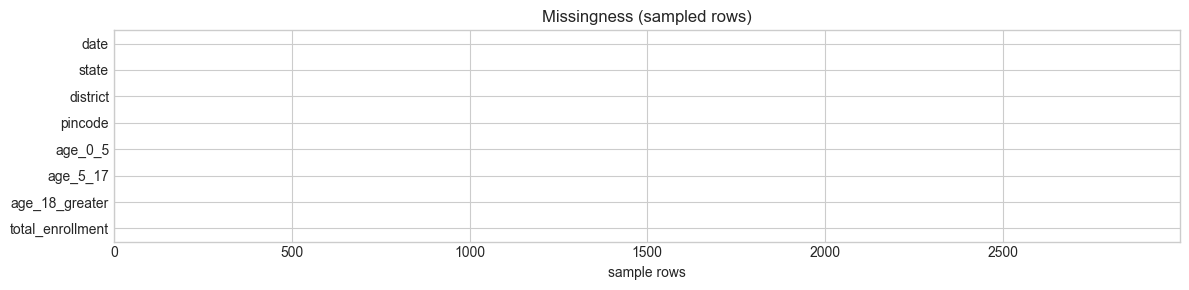

In [74]:
# A2. Missing values & completeness
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean()*100).sort_values(ascending=False)
missing_summary = pd.concat([missing_counts, missing_pct], axis=1)
missing_summary.columns = ['missing_count','missing_pct']
print('Columns with missing values (top):')
print(missing_summary[missing_summary['missing_count']>0].head(20))

# Visualize missingness for a sample (large datasets can be expensive)
sample = df.sample(n=min(3000, len(df)), random_state=42)
plt.figure(figsize=(12,3))
plt.imshow(sample.isnull().T, aspect='auto', cmap='gray_r')
plt.yticks(np.arange(len(sample.columns)), sample.columns)
plt.title('Missingness (sampled rows)')
plt.xlabel('sample rows')
plt.tight_layout()
plt.show()

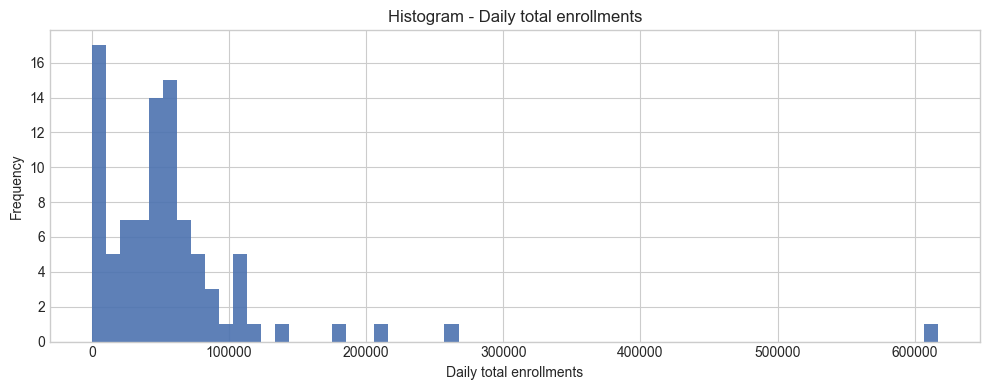

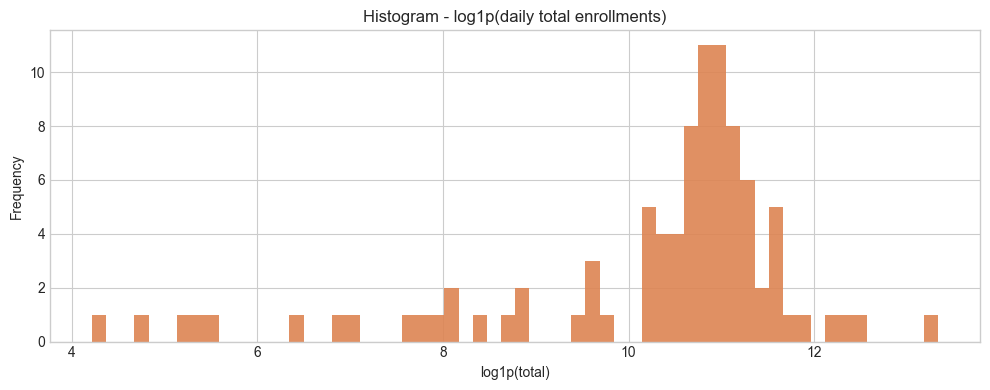

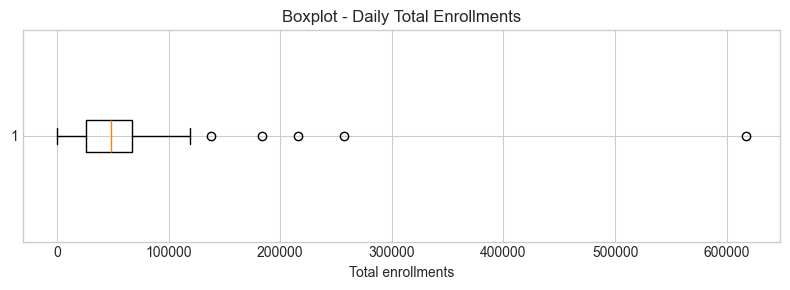

In [75]:
# A3. Distribution analysis: histograms and boxplots
plt.figure(figsize=(10,4))
plt.hist(daily_total['total_enrollment'], bins=60, color='#4C72B0', alpha=0.9)
plt.title('Histogram - Daily total enrollments')
plt.xlabel('Daily total enrollments')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Log histogram
plt.figure(figsize=(10,4))
plt.hist(np.log1p(daily_total['total_enrollment']), bins=60, color='#DD8452', alpha=0.9)
plt.title('Histogram - log1p(daily total enrollments)')
plt.xlabel('log1p(total)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(8,3))
plt.boxplot(daily_total['total_enrollment'], vert=False)
plt.title('Boxplot - Daily Total Enrollments')
plt.xlabel('Total enrollments')
plt.tight_layout()
plt.show()

IQR outliers count: 5
         date  total_enrollment
9  2025-04-01            257438
10 2025-05-01            183616
11 2025-06-01            215734
12 2025-07-01            616868
81 2025-12-15            137986
Z-score outliers count: 1
         date  total_enrollment    zscore
12 2025-07-01            616868  7.623245
Anomalous days by pct-change MAD rule: 19


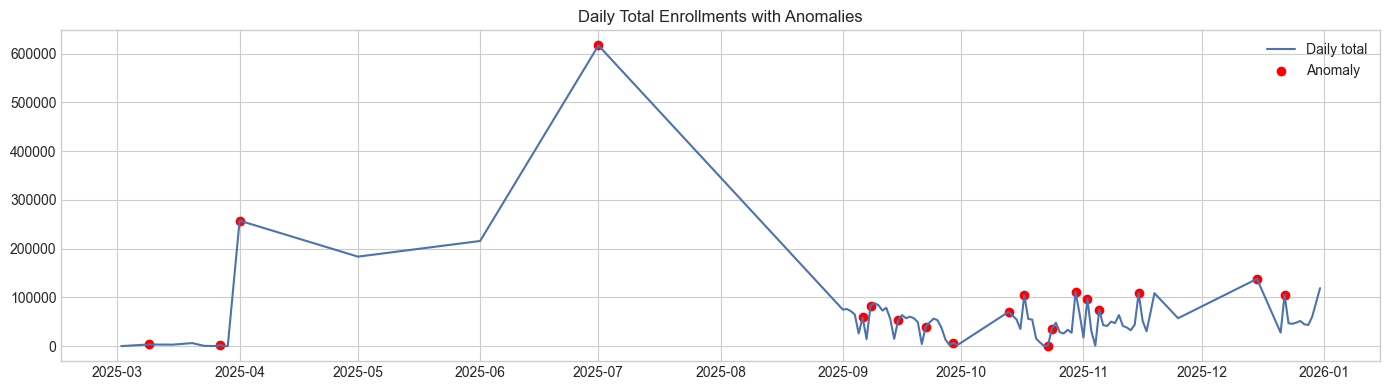

In [76]:
# A4. Outlier & anomaly detection
# IQR-based outliers
q1 = daily_total['total_enrollment'].quantile(0.25)
q3 = daily_total['total_enrollment'].quantile(0.75)
iqr = q3 - q1
lower_bound, upper_bound = q1 - 1.5*iqr, q3 + 1.5*iqr
outliers_iqr = daily_total[(daily_total['total_enrollment'] < lower_bound) | (daily_total['total_enrollment'] > upper_bound)]

# Z-score based
daily_total['zscore'] = stats.zscore(daily_total['total_enrollment'].fillna(0))
outliers_z = daily_total[np.abs(daily_total['zscore']) > 3]

print(f'IQR outliers count: {len(outliers_iqr)}')
print(outliers_iqr.head())
print(f'Z-score outliers count: {len(outliers_z)}')
print(outliers_z.head())

# Anomaly by pct-change using MAD
daily_total['pct_change'] = daily_total['total_enrollment'].pct_change()
mad = np.median(np.abs(daily_total['pct_change'].dropna() - np.median(daily_total['pct_change'].dropna())))
threshold = 3 * mad
anomalies = daily_total[np.abs(daily_total['pct_change'].fillna(0)) > threshold]
print(f'Anomalous days by pct-change MAD rule: {len(anomalies)}')

# mark anomalies on series
plt.figure(figsize=(14,4))
plt.plot(daily_total['date'], daily_total['total_enrollment'], color='#4C72B0', label='Daily total')
if not anomalies.empty:
    plt.scatter(anomalies['date'], anomalies['total_enrollment'], color='red', label='Anomaly')
plt.title('Daily Total Enrollments with Anomalies')
plt.legend()
plt.tight_layout()
plt.show()

Top 10 states - totals:
         state  total_enrollment
 Uttar Pradesh           1002530
         Bihar            593734
Madhya Pradesh            487682
   West Bengal            367596
   Maharashtra            362796
     Rajasthan            340534
       Gujarat            274897
         Assam            225502
     Karnataka            216273
    Tamil Nadu            214755

Top 10 districts - totals:
         district  total_enrollment
Paschim Champaran             46271
  Purbi Champaran             43767
            Thane             43142
        Sitamarhi             41652
         Bahraich             38897
   Uttar Dinajpur             38449
South 24 Parganas             37446
North 24 Parganas             35847
      Murshidabad             34968
             Pune             31148


<Figure size 1200x500 with 0 Axes>

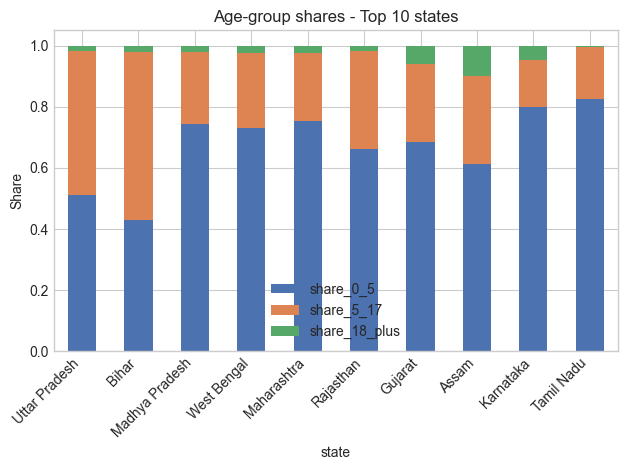

In [77]:
# A5. Summary tables and age-group shares (state & district)
# Totals by state
state_totals = df.groupby('state', as_index=False)[age_cols + ['total_enrollment']].sum()
state_totals = state_totals.sort_values('total_enrollment', ascending=False)
state_totals['share_0_5'] = state_totals[age_cols[0]] / state_totals['total_enrollment']
state_totals['share_5_17'] = state_totals[age_cols[1]] / state_totals['total_enrollment']
state_totals['share_18_plus'] = state_totals[age_cols[2]] / state_totals['total_enrollment']

print('Top 10 states - totals:')
print(state_totals[['state','total_enrollment']].head(10).to_string(index=False))

# Totals by district
district_totals = df.groupby('district', as_index=False)[age_cols + ['total_enrollment']].sum()
district_totals = district_totals.sort_values('total_enrollment', ascending=False)
print('\nTop 10 districts - totals:')
print(district_totals[['district','total_enrollment']].head(10).to_string(index=False))

# Plot age share stacked bar for top 10 states
plot_df = state_totals.head(10).set_index('state')
plt.figure(figsize=(12,5))
plot_df[[ 'share_0_5', 'share_5_17', 'share_18_plus']].plot(kind='bar', stacked=True, color=['#4C72B0', '#DD8452', '#55A868'])
plt.title('Age-group shares - Top 10 states')
plt.ylabel('Share')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Deliverables (Part A)
- Descriptive tables: `state_totals`, `district_totals`
- Figures: daily time series, histograms, boxplot, missingness map, anomaly-marked series, age-group shares

Next: If you'd like, I can run seasonality decomposition on `daily_total`, add changepoint detection, or perform per-state ANOVA / Kruskal-Wallis tests to compare distributions across states. Which analysis should I add next?

Statistical Testing

In [20]:
# -----------------------------
# ANOMALY DETECTION (Z-SCORE)
# -----------------------------
df['z'] = (df['total_enrollment'] - df['total_enrollment'].mean()) / df['total_enrollment'].std()
anomalies = df[df['z'].abs() > 3]
print("\nDetected Anomalies (Z-Score > 3):")
print(f"Number of anomalies: {len(anomalies)}")
if len(anomalies) > 0:
    print(anomalies[['date','state','district','total_enrollment','z']].sort_values('z', ascending=False))


Detected Anomalies (Z-Score > 3):
Number of anomalies: 2940
             date          state          district  total_enrollment  \
782317 2025-07-01  Uttar Pradesh         Moradabad              3965   
431059 2025-07-01    Maharashtra        Aurangabad              3835   
509187 2025-04-01      Meghalaya  West Khasi Hills              3027   
782269 2025-07-01  Uttar Pradesh            Hardoi              3006   
782244 2025-07-01  Uttar Pradesh         Firozabad              2990   
...           ...            ...               ...               ...   
624572 2025-11-15      Rajasthan           Jodhpur               102   
509194 2025-05-01      Meghalaya  East Khasi Hills               102   
55556  2025-07-01          Assam           Chirang               102   
267416 2025-11-05      Jharkhand         Sahebganj               102   
899774 2025-07-01    West Bengal             Nadia               102   

                 z  
782317  123.423569  
431059  119.371312  
509187   94

Weekend vs Weekday Enrollment Test
Weekday mean: 5.66, std: 34.09
Weekend mean: 4.83, std: 24.51
Weekday normality p-value: 0.0000
Weekend normality p-value: 0.0000
Mann-Whitney U test: p-value = 0.0000
Significant difference: Enrollments differ on weekends vs weekdays.


C:\Users\SINDHU\AppData\Local\Temp\ipykernel_23400\3128818279.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([weekday_enrollments, weekend_enrollments], labels=['Weekday', 'Weekend'])


Plot saved to S:\UIDAI_Hackathon\svg_outputs\weekend_vs_weekday_plot.svg


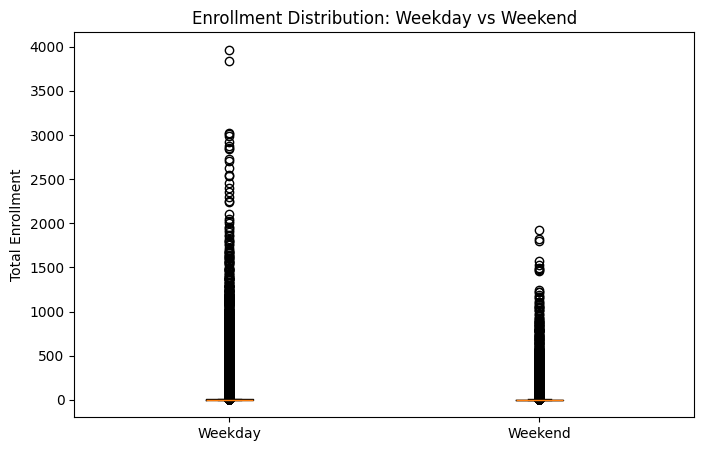

In [16]:
# Cell 23: WEEKEND vs WEEKDAY TEST
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# Assuming df is already loaded from previous cells
df = pd.read_csv(r'S:\UIDAI_Hackathon\api_data_aadhar_enrolment\merged_final.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['total_enrollment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

# Add weekday/weekend indicator
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]) # 5=Saturday, 6=Sunday

# Group by weekend/weekday
weekday_enrollments = df[~df['is_weekend']]['total_enrollment']
weekend_enrollments = df[df['is_weekend']]['total_enrollment']

print("Weekend vs Weekday Enrollment Test")
print(f"Weekday mean: {weekday_enrollments.mean():.2f}, std: {weekday_enrollments.std():.2f}")
print(f"Weekend mean: {weekend_enrollments.mean():.2f}, std: {weekend_enrollments.std():.2f}")

# Check normality for t-test
weekday_norm = stats.shapiro(weekday_enrollments.sample(min(5000, len(weekday_enrollments))))
weekend_norm = stats.shapiro(weekend_enrollments.sample(min(5000, len(weekend_enrollments))))
print(f"Weekday normality p-value: {weekday_norm.pvalue:.4f}")
print(f"Weekend normality p-value: {weekend_norm.pvalue:.4f}")

# Use t-test if normal, else Mann-Whitney
if weekday_norm.pvalue > 0.05 and weekend_norm.pvalue > 0.05:
    t_stat, p_value = stats.ttest_ind(weekday_enrollments, weekend_enrollments)
    test_name = "Two-sample t-test"
else:
    u_stat, p_value = stats.mannwhitneyu(weekday_enrollments, weekend_enrollments)
    test_name = "Mann-Whitney U test"

print(f"{test_name}: p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Significant difference: Enrollments differ on weekends vs weekdays.")
else:
    print("No significant difference.")

# Visualization
plt.figure(figsize=(8,5))
plt.boxplot([weekday_enrollments, weekend_enrollments], labels=['Weekday', 'Weekend'])
plt.title('Enrollment Distribution: Weekday vs Weekend')
plt.ylabel('Total Enrollment')

# --- ADDED: Export to SVG ---
output_path = r'S:\UIDAI_Hackathon\svg_outputs\weekend_vs_weekday_plot.svg'
plt.savefig(output_path, format='svg', bbox_inches='tight')
print(f"Plot saved to {output_path}")
# -----------------------------

plt.show() # Call show last to avoid blank images


Seasonal Effect Test (ANOVA by Month)
F-statistic: 136833.65, p-value: 0.0000
Significant seasonal effects: Months have different mean enrollments.


<Figure size 1000x600 with 0 Axes>

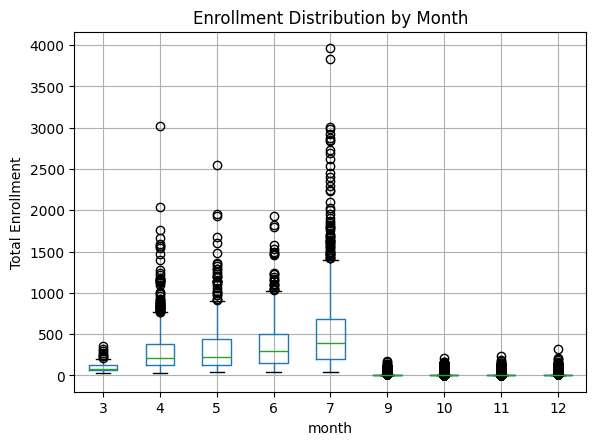

In [7]:
# Cell 26: SEASONAL EFFECT TEST

# Add month column
df['month'] = df['date'].dt.month

# Group enrollments by month
month_groups = [group['total_enrollment'].values for name, group in df.groupby('month')]

# ANOVA
f_stat, p_value = stats.f_oneway(*month_groups)

print("Seasonal Effect Test (ANOVA by Month)")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Significant seasonal effects: Months have different mean enrollments.")
else:
    print("No significant seasonal effects.")

# Visualization: Boxplot by month
plt.figure(figsize=(10,6))
df.boxplot(column='total_enrollment', by='month')
plt.title('Enrollment Distribution by Month')
plt.suptitle('')
plt.ylabel('Total Enrollment')
plt.show()

In [8]:
df['week_of_month'] = (df['date'].dt.day - 1) // 7 + 1

week_groups = [group['total_enrollment'].values for name, group in df.groupby('week_of_month')]

f_stat, p_value = stats.f_oneway(*week_groups)

print("Week-of-Month Effect Test")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Significant difference across weeks of month.")
else:
    print("No significant difference across weeks of month.")


Week-of-Month Effect Test
F-statistic: 1937.96, p-value: 0.0000
Significant difference across weeks of month.


In [11]:
df['year_week'] = df['date'].dt.isocalendar().week

sample_district = df['district'].value_counts().index[0]

d = df[df['district'] == sample_district]

week_means = d.groupby('year_week')['total_enrollment'].mean()

# Take two consecutive weeks with most data
w1, w2 = week_means.index[:2]

group1 = d[d['year_week'] == w1]['total_enrollment']
group2 = d[d['year_week'] == w2]['total_enrollment']

stat, p_value = stats.mannwhitneyu(group1, group2)

print("Adjacent Week Stability Test")
print("p-value:", p_value)


Adjacent Week Stability Test
p-value: 0.073761124701462


In [13]:
sample = df.sample(n=50000, random_state=42)

half = len(sample) // 2

group1 = sample['total_enrollment'].iloc[:half]
group2 = sample['total_enrollment'].iloc[half:]

stat, p_value = stats.mannwhitneyu(group1, group2)

print("Random Split Equality Test")
print("p-value:", p_value)


Random Split Equality Test
p-value: 0.14690542576136195


In [14]:
state_list = df['state'].unique()[:2]

s1 = df[df['state'] == state_list[0]]
s2 = df[df['state'] == state_list[1]]

prop1 = (s1['age_0_5'] + s1['age_5_17']) / s1['total_enrollment']
prop2 = (s2['age_0_5'] + s2['age_5_17']) / s2['total_enrollment']

stat, p_value = stats.mannwhitneyu(prop1.dropna(), prop2.dropna())

print("Age Proportion Similarity Test Between States")
print("p-value:", p_value)


Age Proportion Similarity Test Between States
p-value: 0.012201110770163158
